# Changepoint detection and deviation detection
Notebook containing experimental evaluation of deviation detection methods.

In [1]:
import numpy as np
import os, sys
import math
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
#from my_functions import *
from modules.preprocessing import *
#from modules.statistics import *
#from modules.io import *
from modules.learning import *
from scipy import stats
from ast import literal_eval

from modules.experiments import *
import matplotlib.dates as mdates


## Read data
Read input time series. Manual washing dates are given as input. 

In [2]:
def parse_csv(filename):
    df_meta = pd.read_csv(filename, nrows=1)
    df_temp = pd.read_csv(filename, sep='\n', header=None, names=["temp"])
    col_names = df_temp.temp.iloc[2].split(',')
    col_names.extend(['I-V Curve I Values', 'I-V Curve V Values'])
    rows = []
    num_r = df_temp.iloc[3:].shape[0]
    
    # handle columns
    for i in range(num_r):
        data = df_temp.temp.loc[3+i].split(',')
        N = int(data[41])
        rows.append(data[:42])
        rows[i].extend([np.array(data[42:42+N]), np.array(data[42+N:])])
    df = pd.DataFrame(columns=col_names, data=rows)
    
    # convert to datetime
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce') 
    
    # convert to datetime.time (99:99 will be replaced with nan)
    df.iloc[:, 38] = pd.to_datetime(df.iloc[:, 38], format= '%H:%M', errors='coerce').dt.time
    df.iloc[:, 39] = pd.to_datetime(df.iloc[:, 39], format= '%H:%M', errors='coerce').dt.time
    
    # infer and convert to appropriate types for each column
    idx = [0, 38, 39, 42, 43]
    for j in range(1, df.shape[1]):
        if j in idx:
            continue
        df.iloc[:, j] = df.iloc[:, j].apply(literal_eval)
        
    # replace -9999 precipitation with nan
    idx1 = [x for x in list(range(df.shape[1])) if x not in idx]
    df.iloc[:, idx1] = df.iloc[:, idx1].replace(-9999, np.nan)
    
    return df_meta, df

In [3]:
filename = '/data/data1/data-for-validating-models/Data For Validating Models/Eugene/Eugene_mSi0188.csv'
dates_wash_start = pd.to_datetime(pd.Series(['2013-03-11 00:00:00', '2013-07-10 00:00:00', '2013-08-14 00:00:00', '2013-08-21 00:00:00', '2013-08-26 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2013-03-12 00:00:00', '2013-07-11 00:00:00', '2013-08-15 00:00:00', '2013-08-22 00:00:00','2013-08-27 00:00:00']))
df_meta, df = parse_csv(filename)

df = df.iloc[:, [0, 1, 3, 5, 7, 9, 11, 13, 22, 26, 27, 30, 33, 37]]

df.columns = ['timestamp', 'irradiance', 'mod_temp', 'Shortcircuitcurrent', 'power',
               'dcurrent','Voltageatmax',
               'Opencircuitvoltage', 'humidity', 'precipitation', 'dni', 'ghi', 'dhi', 'soiling_derate']

df = df.set_index('timestamp')
df = df.dropna()

## Rescale
Use MinMaxScaler to rescale all points to [0,1].

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [5]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41670 entries, 2012-12-20 10:40:02 to 2014-01-20 16:45:02
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   irradiance           41670 non-null  float64
 1   mod_temp             41670 non-null  float64
 2   Shortcircuitcurrent  41670 non-null  float64
 3   power                41670 non-null  float64
 4   dcurrent             41670 non-null  float64
 5   Voltageatmax         41670 non-null  float64
 6   Opencircuitvoltage   41670 non-null  float64
 7   humidity             41670 non-null  float64
 8   precipitation        41670 non-null  float64
 9   dni                  41670 non-null  float64
 10  ghi                  41670 non-null  float64
 11  dhi                  41670 non-null  float64
 12  soiling_derate       41670 non-null  float64
dtypes: float64(13)
memory usage: 4.5 MB


In [6]:
df_scaled.describe()

,irradiance,mod_temp,Shortcircuitcurrent,power,dcurrent,Voltageatmax,Opencircuitvoltage,humidity,precipitation,dni,ghi,dhi,soiling_derate
count,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000
mean,0.240040,0.488759,0.242939,0.229354,0.239599,0.552331,0.606761,0.623341,0.027583,0.339249,0.237523,0.129672,0.906683
std,0.236484,0.176826,0.238951,0.227015,0.238184,0.140278,0.144980,0.225187,0.089349,0.391078,0.209455,0.107905,0.189237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.045438,0.349922,0.047995,0.042359,0.045305,0.493751,0.539460,0.446250,0.000000,0.004215,0.068020,0.056834,0.861111
50%,0.136528,0.461897,0.136770,0.128678,0.132569,0.587347,0.635596,0.653750,0.000000,0.026693,0.159569,0.089934,1.000000
75%,0.419793,0.622084,0.420410,0.405196,0.417268,0.645686,0.702377,0.815000,0.004184,0.792875,0.369035,0.169876,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract rains
Use precipitation values to extract rains. Each rain corresponds to a maximal period of positive precipitation.

In [7]:
if df.precipitation.iloc[0]>0:
    precipitation = pd.concat([pd.Series({min(df.index)-pd.Timedelta('1s'): 0}),df.precipitation])
else:
    precipitation = df.precipitation

precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

Number of rains:

In [8]:
dates_rain_stop.shape[0]

69

### Filter out light rains
Any rain with maximum precipitation less than x is considered light.

In [9]:
x = 0.1
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= x:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [10]:
dates_rain_stop_filtered.shape[0]

69

### Regression model trained after manual cleanings 
Train a regression model on periods of w_train days after the manual washings of the panels.

In [11]:
w_train = 30
feats = ['irradiance', 'mod_temp']
target = 'power'
ref_points2 = pd.Index(dates_wash_stop)
model2, training_error2, validation_error2 = train_on_reference_points(df_scaled, w_train, ref_points2, feats, target)
validation_error2

Training Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.029 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.030 
MPE:-0.000 
R2: 0.998



array([ 9.98135047e-01,  7.41077772e-03, -5.78349293e-05,  2.96083337e-02,
       -2.31068310e-04,  2.50896395e-03])

## Detect changepoints

Two methods for detecting changepoints. 
Method 1. For each rain (or manual cleaning), we train and validate a regression model in the time period right before it, and we test it in the time period right after it. We then employ a score function which ranks preferably those rains with a small error before them and a large error after them. 
Method 2. We use the model trained on periods succeeding manual cleanings. For each rain (or manual cleaning), we measure the prediction error in the time period right before it, and the prediction error in the time period right after it. We then employ a score function which ranks preferably those rains with a large error before them and a small error after them.

### Initialize parameters

In [12]:
w1 = 10  # window of days to train (before the rain)
w2 = 5 # window of days to validate (before the rain)
w3 = 10 # window of days to test (after the rain)

error_br_column = 5 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe, 5=median error
error_ar_column = 5
thrsh = 1

In [13]:
errors_br1 = np.empty((dates_rain_start_filtered.size, 6))
errors_ar1 = np.empty((dates_rain_start_filtered.size, 6))
scores = np.empty((dates_rain_start_filtered.size))
indices = np.empty(len(scores), dtype=int)
error_names = {0: "r_squared", 1: "MAE", 2: "ME (true-pred)", 3: "MAPE", 4: "MPE (true-pred)", 5: "Median error"}

### Detect changepoints

In [14]:
p_changepoints_start = (pd.Series(dates_rain_start_filtered.tolist() + dates_wash_start.tolist()).sort_values())
p_changepoints_stop = (pd.Series(dates_rain_stop_filtered.tolist() + dates_wash_stop.tolist()).sort_values())
target = 'power'
feats = ['irradiance', 'mod_temp']
error_name_br = error_names[error_br_column] 
error_name_ar = error_names[error_ar_column]

#compute errors using one model per rain
errors_br1, errors_ar1 = calc_changepoints_many_models(df_scaled, p_changepoints_start, p_changepoints_stop, target, feats, w1, w2, w3 )
errors_br2, errors_ar2 = calc_changepoints_one_model(df_scaled, p_changepoints_start, p_changepoints_stop, model2, target, feats, 5, 10)

#set threshold on MAPE error before rain
mask1 = (errors_br1[:,3]<= 0.05)
mask2 = (errors_ar2[:,3]<= 0.05)

#compute scores for the remaining
scores1 = -(errors_br1[:, error_br_column]-errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])
scores1[(~mask1)] = np.finfo('d').min

scores2 = -(errors_br2[:, error_br_column]-errors_ar2[:, error_ar_column])/np.abs(errors_ar2[:, error_ar_column])
scores2[(~mask2)] = np.finfo('d').min

#sort
indices1 = np.argsort(-scores1)
indices2 = np.argsort(-scores2)

#compute final output
precip = df.precipitation
df_events_output1=pd.DataFrame(output_changepoints(scores1, indices1, p_changepoints_start, p_changepoints_stop, errors_br1[:, error_br_column], errors_ar1[:, error_ar_column], error_name_br, error_name_ar, precip))
df_events_output2=pd.DataFrame(output_changepoints(scores2, indices2, p_changepoints_start, p_changepoints_stop, errors_br2[:, error_br_column], errors_ar2[:, error_ar_column], error_name_br, error_name_ar, precip))

# effective changepoints = the ones with score at least thrsh  
mask1 = (df_events_output1['Score']>thrsh)
mask2 = (df_events_output2['Score']>thrsh)

effective_cp1 = df_events_output1[mask1]["id"].values 
effective_cp2 = df_events_output2[mask2]["id"].values 

print(f'Number of "effective" changepoints using Method 1: {len(set(effective_cp1))}') 
print(f'Number of "effective" changepoints using Method 2: {len(set(effective_cp2))}') 



Number of "effective" changepoints using Method 1: 23
Number of "effective" changepoints using Method 2: 9


### Train model after changepoints computed by Method 1

In [15]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)]))
model1, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.006 
ME(true-pred):-0.000 
MAPE:0.027 
R2: 0.998

Validation Metrics:
MAE:0.006 
ME(true-pred):0.000 
MAPE:0.027 
MPE:0.000 
R2: 0.998



array([9.98453888e-01, 6.28065169e-03, 1.49303083e-05, 2.67642784e-02,
       6.36238002e-05, 1.18265552e-03])

### Train model after changepoints computed by Method 2

In [16]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)]))
model3, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.027 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):0.000 
MAPE:0.027 
MPE:0.000 
R2: 0.998



array([9.98190341e-01, 7.19509461e-03, 2.57552985e-06, 2.67620444e-02,
       9.57964387e-06, 1.33343898e-03])

### Compare three regression models

<class 'pandas.core.series.Series'>


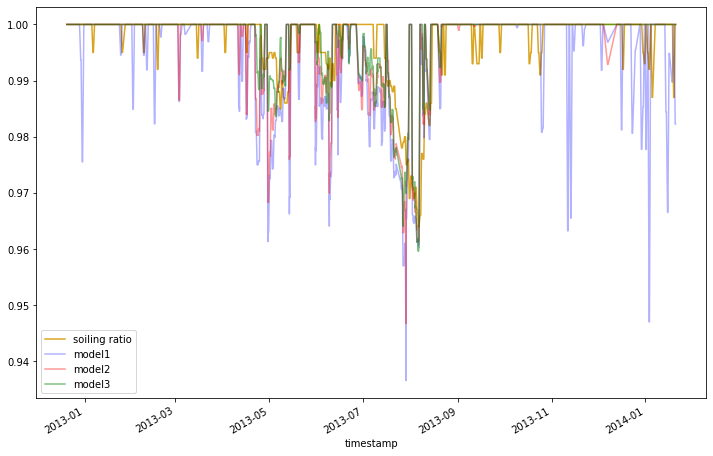

In [17]:
y_pred1 = predict(df_scaled, model1, feats, target)
y_pred2 = predict(df_scaled, model2, feats, target)
y_pred3 = predict(df_scaled, model3, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.power/y_pred1,1),0.0)
print(type(derate1))
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
derate2 = np.maximum(np.minimum(df_scaled.power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
derate3 = np.maximum(np.minimum(df_scaled.power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax1 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label = 'soiling ratio')
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'model1')
ax1.plot(derate2, color = 'red', alpha = 0.4, label = 'model2')
ax1.plot(derate3, color = 'green', alpha = 0.5, label = 'model3')
plt.legend()

## Segmentation using changepoints obtained by Method 1

In [18]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 1. 

In [19]:
feats = ['irradiance', 'mod_temp']
target = 'power'
slopes = []
mpe_scores = []
sign_slopes = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes.append(-slope)
        sign_slopes.append(np.sign(-slope))
    except:
        sign_slopes.append(np.finfo('d').min)
        slopes.append(np.finfo('d').min)
        mpe_scores.append(1)

### Compute output

In [20]:
indices = np.argsort(np.array(mpe_scores)*(np.array(sign_slopes)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes[j] > 0 and mpe_scores[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes[j]*mpe_scores[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [21]:
df_segments_output

,Score,Starting date,Ending date
0,0.017802,2013-06-20 05:30:02,2013-08-07 17:00:02
1,0.015915,2013-08-11 05:50:02,2013-08-14 00:00:00
2,0.007641,2013-05-17 05:30:02,2013-06-10 07:15:02
3,0.000874,2014-01-09 08:25:02,2014-01-20 16:45:02


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings. 

In [22]:
feats = ['irradiance', 'mod_temp']
target = 'power'
slopes3 = []
mpe_scores3 = []
sign_slopes3 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores3.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes3.append(-slope)
        sign_slopes3.append(np.sign(-slope))
    except:
        sign_slopes3.append(np.finfo('d').min)
        slopes3.append(np.finfo('d').min)
        mpe_scores3.append(1)

### Compute output

In [23]:
indices = np.argsort(np.array(mpe_scores3)*(np.array(sign_slopes3)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes3[j] > 0 and mpe_scores3[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes3[j]*mpe_scores3[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output3 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [24]:
df_segments_output3

,Score,Starting date,Ending date
0,0.014292,2013-06-20 05:30:02,2013-08-07 17:00:02
1,0.013096,2013-08-11 05:50:02,2013-08-14 00:00:00
2,0.007778,2013-04-05 06:30:02,2013-05-15 07:00:02
3,0.002796,2013-05-17 05:30:02,2013-06-10 07:15:02


## Segmentation using changepoints obtained by Method 2

In [25]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])
# these dates are used by the deviation detection tool
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 2. 

In [26]:
feats = ['irradiance', 'mod_temp']
target = 'power'
slopes4 = []
mpe_scores4 = []
sign_slopes4 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores4.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes4.append(-slope)
        sign_slopes4.append(np.sign(-slope))
    except:
        sign_slopes4.append(np.finfo('d').min)
        slopes4.append(np.finfo('d').min)
        mpe_scores4.append(1)



### Compute output

In [27]:
indices = np.argsort(np.array(mpe_scores4)*(np.array(sign_slopes4)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes4[j] > 0 and mpe_scores4[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes4[j]*mpe_scores4[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
       
        line , slope, _ = get_ts_line_and_slope(diff.values)
        
                
df_segments_output4 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [28]:
df_segments_output4

,Score,Starting date,Ending date
0,0.012840,2013-08-11 05:50:02,2013-08-14 00:00:00
1,0.012073,2013-06-20 05:30:02,2013-08-07 17:00:02


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings.

In [29]:
feats = ['irradiance', 'mod_temp']
target = 'power'
slopes2 = []
mpe_scores2 = []
sign_slopes2 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores2.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes2.append(-slope)
        sign_slopes2.append(np.sign(-slope))
    except:
        sign_slopes2.append(np.finfo('d').min)
        slopes2.append(np.finfo('d').min)
        mpe_scores2.append(1)



### Compute output

In [30]:
indices = np.argsort(np.array(mpe_scores2)*(np.array(sign_slopes2)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    #print(f"{d1} - {d2}")
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) ####################
    except:
        d3 = d2
        d4 = d2
    if slopes2[j] > 0 and mpe_scores2[j]<0 and len(df_scaled.loc[d1:d2])>0: #and len(df_scaled.loc[d3:d4])>0:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes2[j]*mpe_scores2[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
        
                
df_segments_output2 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [31]:
df_segments_output2

,Score,Starting date,Ending date
0,0.014292,2013-06-20 05:30:02,2013-08-07 17:00:02
1,0.013096,2013-08-11 05:50:02,2013-08-14 00:00:00
2,0.002796,2013-05-17 05:30:02,2013-06-10 07:15:02


## Plots

### Changepoints

In [32]:
#read output from SRR method
df_cp = pd.read_csv('./temp_filtered.csv')
df_cp.head(2)
starts_of_interv = df_cp.start

In [33]:
dates_changepoints1 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_changepoints2 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])

#### Method 1

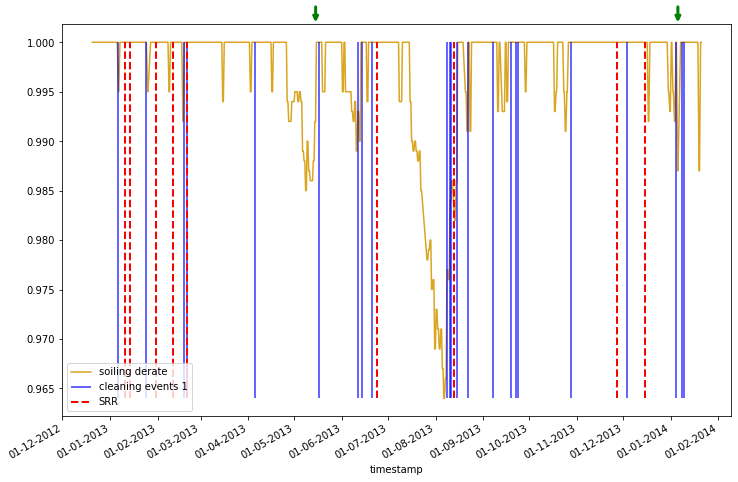

In [34]:
ymin = min(df['soiling_derate'].values)
ax1 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate',figsize=(12,8))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.vlines(x=dates_changepoints1, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')

ax1.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
ax1.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
b=0.92
ax1.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax1.legend()
plt.show()

#### Method 2

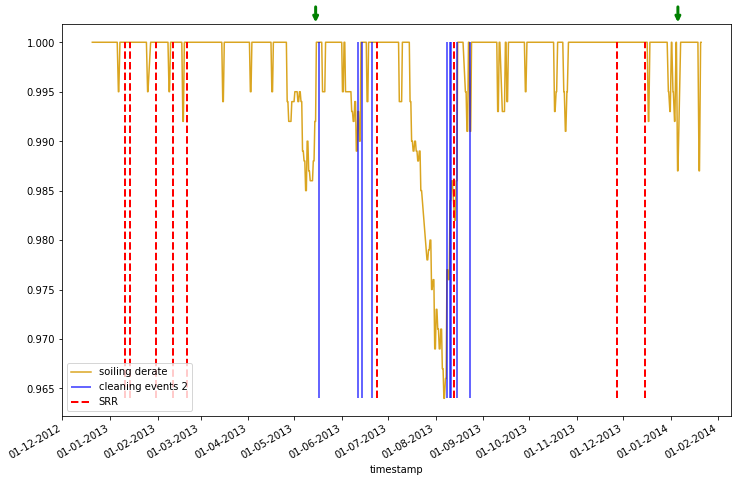

In [35]:
ymin = min(df['soiling_derate'].values)
ax2 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate', figsize=(12,8))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.vlines(x=dates_changepoints2, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')

ax2.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
ax2.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
b=0.92
ax2.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax2.legend()
plt.show()

### Modelled soiling ratio

Filter Complete


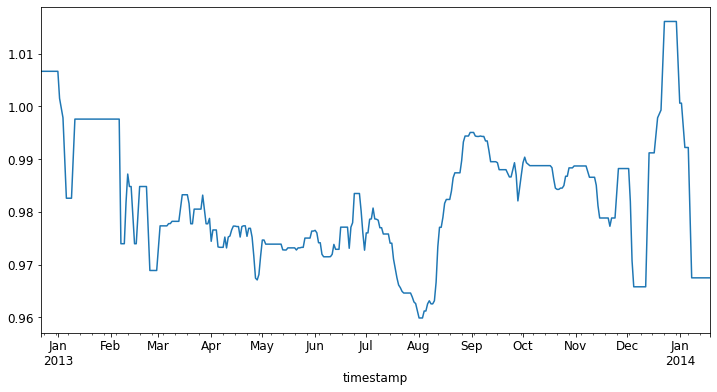

In [36]:
### Generate SRR performance index
import pandas as pd
from solarpaper import *
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import theilslopes
import matplotlib.pyplot as plt
import pvlib
import matplotlib
from modules.preprocessing import *
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [12, 6],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })
df_1 = df

df_1.columns = ['poa', 'mod_temp', 'Shortcircuitcurrent', 'power',
               'dcurrent','Voltageatmax',
               'Opencircuitvoltage', 'humidity', 'precipitation', 'dni', 'ghi', 'dhi', 'soiling_derate']
df_1.index = pd.DatetimeIndex(df_1.index)
df_1 = df_1.dropna()
# FILTER TIME AND IRRADIANCE

start = '12:00'
end = '14:00'
df_1 = df_1.between_time(start, end)
# 0 is the index of irradiance after setting the datetimeindex
df_1 = filter_col(df_1, 0, less_than=500, bigger_than=None)

df_1['powerDC']=df_1['dcurrent']*df_1['Voltageatmax']
df_1['probablnot']=df_1['Shortcircuitcurrent']*df_1['Opencircuitvoltage']
df_1['pvw_dc'] = pvlib.pvsystem.pvwatts_dc(df_1.poa, df_1.mod_temp, 45.91, -0.005)



pm = df_1.power.resample('D').sum() / df_1.pvw_dc.resample('D').sum()
pm.name = 'pi'
df_pm = pm.to_frame()
day_scale = 14

# Normalize pi to 95th percentile
pi = df_pm[df_pm.pi > 0]['pi']
df_pm['pi_norm'] = df_pm.pi / np.percentile(pi, 95)

# Make a forward filled copy, just for use in step, slope change detection
df_ffill = df_pm.fillna(method='ffill', limit=day_scale).copy()

# Calculate rolling median
df_pm['pi_roll_med'] = df_ffill.pi_norm.rolling(day_scale, center=True).median()
df_pm['pi_roll_med'] = df_pm['pi_roll_med'].fillna(method='ffill').copy()
df_pm['pi_roll_med'] = df_pm['pi_roll_med'].fillna(method='bfill').copy()
df_pm['pi_roll_med'].plot()

# keep a daily soiling derate for later
sdd = df_1.soiling_derate.resample('D').mean()
sdd = sdd[df_pm['pi_roll_med'].index]
sdd = sdd.fillna(method='ffill').copy()
sdd = sdd.fillna(method='bfill').copy()

p_index = np.clip(df_pm['pi_roll_med'], 0 , 1)

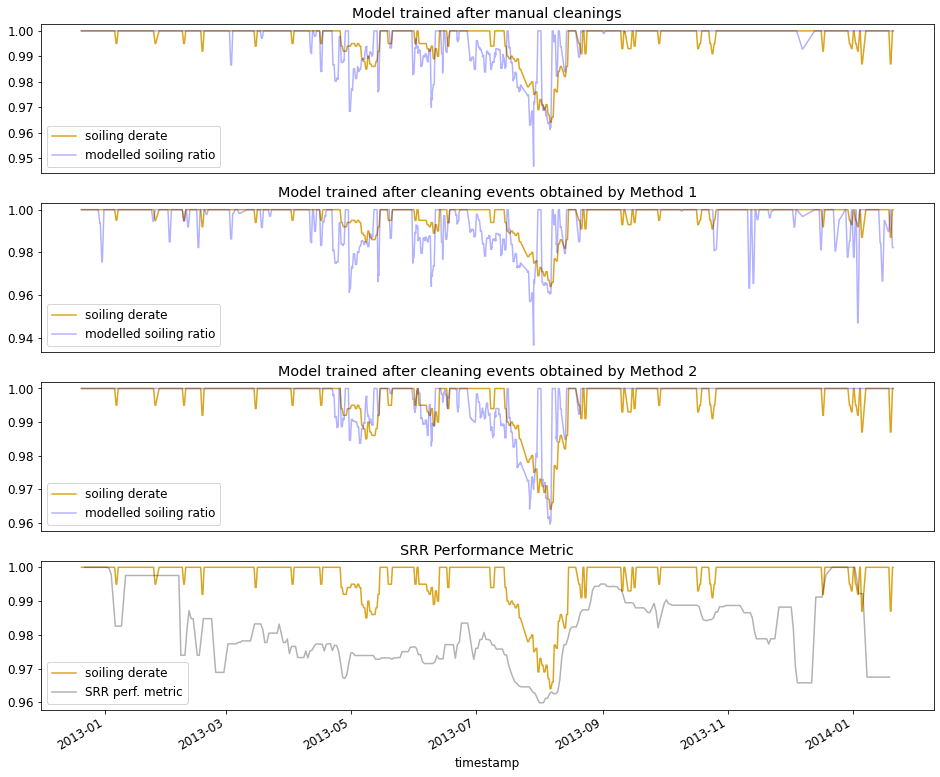

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,14))
#plt.suptitle(f'Changepoint Detection Methods')
axes = axes.ravel()


ax2 = axes[0]
ax2.set_title('Model trained after manual cleanings')
y_pred2 = predict(df_scaled, model2, feats, target)
derate2 = np.maximum(np.minimum(df_scaled.power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
ax2 = df['soiling_derate'].plot(ax = ax2, color = 'goldenrod',label = 'soiling derate')
ax2.plot(derate2, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax2.xaxis.set_visible(False)
ax2.legend()

ax1 = axes[1]
ax1.set_title('Model trained after cleaning events obtained by Method 1')
y_pred1 = predict(df_scaled, model1, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.power/y_pred1,1),0.0)
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
ax1 = df['soiling_derate'].plot(ax = ax1, color = 'goldenrod',label = 'soiling derate')
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax1.xaxis.set_visible(False)
ax1.legend()


ax3 = axes[2]
ax3.set_title('Model trained after cleaning events obtained by Method 2')
y_pred3 = predict(df_scaled, model3, feats, target)
derate3 = np.maximum(np.minimum(df_scaled.power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax3 = df['soiling_derate'].plot(ax = ax3, color = 'goldenrod',label = 'soiling derate')
ax3.plot(derate3, color = 'blue', alpha = 0.3, label = 'modelled soiling ratio')
ax3.xaxis.set_visible(False)
ax3.legend()

ax4 = axes[3]
ax4.set_title('SRR Performance Metric')
ax4 = df['soiling_derate'].plot(ax = ax4, color = 'goldenrod',label = 'soiling derate')
ax4.plot(p_index, color = 'black', alpha = 0.3, label = 'SRR perf. metric')
ax4.legend()
plt.show()

In [38]:
#Calculate RMSE for each model and ssr
from sklearn.metrics import mean_squared_error as mse
gt = df['soiling_derate']
gt_daily = sdd
print(gt.shape)
rmse1 = mse(gt, derate1, squared=False)
rmse2 = mse(gt, derate2, squared=False)
rmse3 = mse(gt, derate3, squared=False)
rmse_srr = mse(gt_daily, p_index, squared=False)
print(f'RMSE derate1 = ', rmse1)
print(f'RMSE derate2 = ', rmse2)
print(f'RMSE derate3 = ', rmse3)
print(f'RMSE     srr = ', rmse_srr)

(41670,)
RMSE derate1 =  0.0092803048965852
RMSE derate2 =  0.006599339798587537
RMSE derate3 =  0.00539639458079099
RMSE     srr =  0.01768970122647233


### Intervals with severe soiling

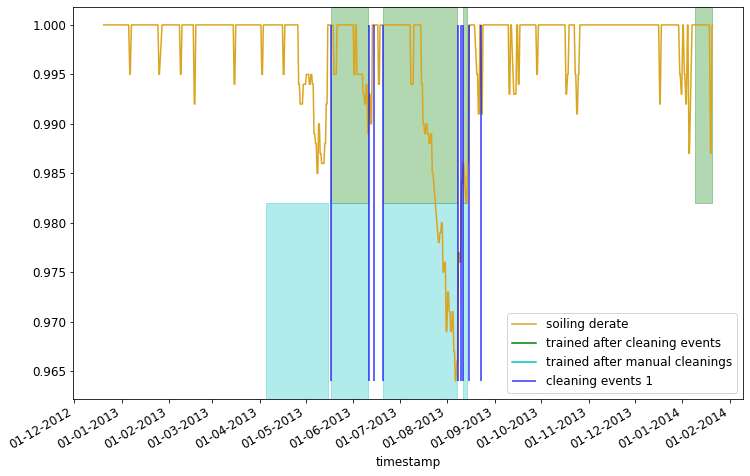

In [39]:
ymin = min(df['soiling_derate'].values)
ax1 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label='soiling derate')
# change the date tick label frequency
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    
for i in range(len(df_segments_output[['Starting date']].values)):
    d1 = df_segments_output[['Starting date']].values[i][0]
    d2 = df_segments_output[['Ending date']].values[i][0]
    ax1.axvspan(d1, d2, color = 'g',ymin = 0.5, ymax=1, alpha = 0.3) 
ax1.plot([],[],label = 'trained after cleaning events',color = 'g') 
for i in range(len(df_segments_output3[['Starting date']].values)):
    d1 = df_segments_output3[['Starting date']].values[i][0]
    d2 = df_segments_output3[['Ending date']].values[i][0]
    ax1.axvspan(d1, d2, color = 'c',ymax=0.5, alpha = 0.3) 
ax1.plot([],[],label = 'trained after manual cleanings',color = 'c') 

#ax1.vlines(x=dates_changepoints2.values, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='changepoints2')
ax1.vlines(x=dates_changepoints.values, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')

plt.legend()
plt.show()

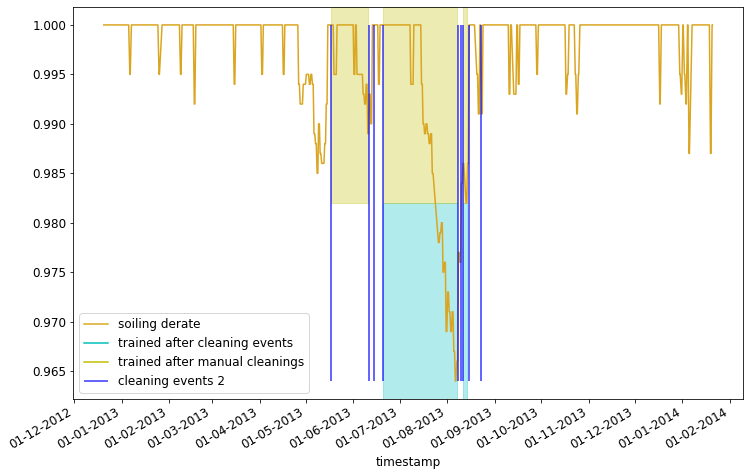

In [40]:
ymin = min(df['soiling_derate'].values)
ax2 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label='soiling derate')
# change the date tick label frequency
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
  
for i in range(len(df_segments_output4[['Starting date']].values)):
    d1 = df_segments_output4[['Starting date']].values[i][0]
    d2 = df_segments_output4[['Ending date']].values[i][0]
    ax2.axvspan(d1, d2, color = 'c',ymax=0.5, alpha = 0.3) 
ax2.plot([],[],label = 'trained after cleaning events',color = 'c')


for i in range(len(df_segments_output2[['Starting date']].values)):
    d1 = df_segments_output2[['Starting date']].values[i][0]
    d2 = df_segments_output2[['Ending date']].values[i][0]
    ax2.axvspan(d1, d2, color = 'y', ymin=0.5, ymax=1, alpha = 0.3)  
ax2.plot([],[],label = 'trained after manual cleanings',color = 'y')    

#changepoints2
ax2.vlines(x=dates_changepoints2, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')
plt.legend()
plt.show()

### Ranking of intervals

First compute groundtruth ranking of intervals: use changepoints obtained by Method 1 and rank them using score function 1-mean(soiling derate).

In [41]:
dates_start1 = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_stop1 = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_start1 = dates_start1.union([max(df.index)])
dates_stop1 = dates_stop1.union([min(df.index)])

dates_start2 = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_stop2 = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_start2 = dates_start2.union([max(df.index)])
dates_stop2 = dates_stop2.union([min(df.index)])



all_scores = []
all_dates_start = []
all_dates_end = []
for d2 in dates_start1:
    d1 = dates_stop1[dates_stop1.get_loc(d2, method='pad')]
    all_scores.append(1-np.mean(df[d1:d2].soiling_derate))
    all_dates_start.append(d1)
    all_dates_end.append(d2)
groundtruth_cp1 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    

all_scores = []
all_dates_start = []
all_dates_end = []
for d2 in dates_start2:
    d1 = dates_stop2[dates_stop2.get_loc(d2, method='pad')]
    all_scores.append(1-np.mean(df[d1:d2].soiling_derate))
    all_dates_start.append(d1)
    all_dates_end.append(d2)
groundtruth_cp2 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


In [42]:
groundtruth_cp1.sort_values(by=['Score'], ascending=False)
true_indices1 = list(groundtruth_cp1.sort_values(by=['Score'], ascending=False)[['Starting date']].index)

groundtruth_cp2.sort_values(by=['Score'], ascending=False)
true_indices2 = list(groundtruth_cp2.sort_values(by=['Score'], ascending=False)[['Starting date']].index)

Our ranked lists:

In [43]:
#to be compared with true_indices1 
our_indices1 = []
for d in df_segments_output[['Starting date']].values:
    our_indices1.append(dates_stop1.get_loc(pd.to_datetime(d[0]),method='nearest'))
    
#to be compared with true_indices2     
our_indices2 = []
for d in df_segments_output2[['Starting date']].values:
    our_indices2.append(dates_stop2.get_loc(pd.to_datetime(d[0]),method='nearest'))
    
#to be compared with true_indices1     
our_indices3 = []
for d in df_segments_output3[['Starting date']].values:
    our_indices1.append(dates_stop1.get_loc(pd.to_datetime(d[0]),method='nearest'))    
    
#to be compared with true_indices2     
our_indices4 = []
for d in df_segments_output4[['Starting date']].values:
    our_indices4.append(dates_stop2.get_loc(pd.to_datetime(d[0]),method='nearest'))    

Calculate the Rank Biased Overlap (RBO) measure.

In [44]:
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

print('1st:')
# example comparison
for i in range(7,9):
    print(f'{rbo(true_indices1 , our_indices1, i/10)} - {i/10}')
    
print('2nd:')    
for i in range(7,9):
    print(f'{rbo(true_indices2 , our_indices4, i/10)} - {i/10}')
  

1st:
0.29817941001674014 - 0.7
0.32873421775097855 - 0.8
2nd:
0.27924369456666664 - 0.7
0.28824550318730163 - 0.8
